In [20]:
# pip install geopandas geobre

In [21]:
import requests
from google.cloud import storage
import gcsfs
import os
import bigframes.pandas as bf
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib.pyplot as plt
from geobr import read_state



In [5]:

client = bigquery.Client()

<ipython-input-5-aab8a4255eba>:1: UnknownLocationWarning: The location 'us' is set to an unknown value.
  bf.options.bigquery.location = "us" #this variable is set based on the dataset you chose to query


In [2]:
bronze_table_id = "temas_ambientais.temas-ambientais_bronze"
query = f"SELECT * FROM `{bronze_table_id}`"
bronze_df = client.query(query).to_dataframe()

# Limpar dados nulos
silver_df = bronze_df.dropna()

# Salvar a tabela limpa como uma nova tabela silver
silver_table_id = "temas_ambientais.temas-ambientais_silver"
job_config = bigquery.LoadJobConfig(write_disposition="WRITE_TRUNCATE")
job = client.load_table_from_dataframe(silver_df, silver_table_id, job_config=job_config)
job.result()

print(f"Dados salvos na tabela {silver_table_id}")

Dados salvos na tabela temas_ambientais.temas-ambientais_silver


## Consulta 1
Recupere a soma de área (em hectares) para todas as propriedades agrícolas que pertencem ao MS e MT. Ordene os resultados em ordem decrescente.

------

- Vamos primeiro criar uma tabela com as areas totais para cada estado e salvar bon banco Gold.
- Depois basta fazer a consulta para os dois estados

In [6]:
# Definir a consulta para somar as áreas por estado
create_gold_table_query = """
CREATE OR REPLACE TABLE `temas_ambientais.temas-ambientais_gold` AS
SELECT
  uf,
  SUM(area_do_imovel) AS total_area
FROM
  `temas_ambientais.temas-ambientais_silver`
GROUP BY
  uf
"""

In [7]:
query_job = client.query(create_gold_table_query)
query_job.result()

In [8]:
query_ms_mt = """
SELECT
  uf,
  total_area
FROM
  `temas_ambientais.temas-ambientais_gold`
WHERE
  uf IN ('MS', 'MT')
ORDER BY
  total_area DESC
"""

In [9]:
query_job = client.query(query_ms_mt)
results = query_job.result()

for row in results:
    print(f"UF: {row.uf}, Total Area: {row.total_area}")

UF: MT, Total Area: 48778752.52629986
UF: MS, Total Area: 11617717.605899919


## Consulta 2

Filtre todas as propriedades que pertecem a região sudeste.

In [10]:
create_gold_table_query = """
CREATE OR REPLACE TABLE `temas_ambientais.temas-ambientais_gold` AS
SELECT
  uf,
  SUM(area_do_imovel) AS total_area
FROM
  `temas_ambientais.temas-ambientais_silver`
GROUP BY
  uf
"""

In [11]:
query_job = client.query(create_gold_table_query)
query_job.result()

In [12]:
query_sudeste = """
SELECT
  *
FROM
  `temas_ambientais.temas-ambientais_silver`
WHERE
  uf IN ('SP', 'RJ', 'MG', 'ES')
"""

In [13]:
query_job = client.query(query_sudeste).to_dataframe()

query_job.head()

,uf,municipio,codigo_ibge,area_do_imovel,registro_car,situacao_cadastro,condicao_cadastro,area_liquida,area_remanescente_vegetacao_nativa,area_reserva_legal_proposta,...,data_alteracao_condicao_cadastro,area_rural_consolidada,area_servidao_administrativa,tipo_imovel_rural,modulos_fiscais,area_uso_restrito,area_reserva_legal_averbada,area_reserva_legal_aprovada_nao_averbada,area_pousio,data_ultima_retificacao
0,RJ,Valença,3306107,35.7718,RJ-3306107-A24C0AA383F94CD9A671C296C9A44020,AT,"Aguardando análise, não passível de revisão de...",35.3306,4.834393,7.0693,...,2021-08-16 20:56:54.07,30.145200,0.441107,IRU,1.4905,0.0,0.0,0.0,0.0,2021-08-16 20:56:35.757
1,RJ,Seropédica,3305554,5.8245,RJ-3305554-89D35C4D8A7A40118C4E69DB14894FFE,AT,"Aguardando análise, não passível de revisão de...",5.8245,0.000000,1.1663,...,2021-05-27 20:51:44.344,5.824458,0.000000,IRU,0.5824,0.0,0.0,0.0,0.0,2021-05-27 20:51:29.305
2,RJ,Nova Friburgo,3303401,5.5754,RJ-3303401-5AD78B5E8B934D728942B13AC305F2D3,AT,"Aguardando análise, não passível de revisão de...",5.5754,0.000000,0.0000,...,2021-06-21 18:18:30.925,5.575352,0.000000,IRU,0.5575,0.0,0.0,0.0,0.0,2021-06-21 18:18:19.733
3,RJ,Campos dos Goytacazes,3301009,9.4120,RJ-3301009-59B44C8C2C2446369A0120AAE9B65241,AT,"Aguardando análise, não passível de revisão de...",9.4120,0.000000,1.9132,...,2021-10-28 20:27:50.69,9.412043,0.000000,IRU,0.7843,0.0,0.0,0.0,0.0,2021-10-28 20:27:32.123
4,RJ,Bom Jesus do Itabapoana,3300605,459.7891,RJ-3300605-2F63A5B3CCF2489BAFF93AC783C840BD,AT,"Aguardando análise, não passível de revisão de...",459.7891,50.485838,50.4858,...,2021-11-01 11:29:52.491,408.986926,0.000000,IRU,15.3263,0.0,0.0,0.0,0.0,2021-11-01 11:29:38.544


## Consulta 3
Calcule quantas propriedades foram cadastradas por ano. Apresente os resultados em ordem cronológica.

In [14]:
count_properties_per_year_query = """
SELECT
  EXTRACT(YEAR FROM TIMESTAMP(data_ultima_retificacao)) AS ano,
  COUNT(*) AS num_propriedades
FROM
  `temas_ambientais.temas-ambientais_silver`
GROUP BY
  ano
ORDER BY
  ano
"""


In [15]:

query_job = client.query(count_properties_per_year_query)
results = query_job.result()


for row in results:
    print(f"Ano: {row.ano}, Número de Propriedades: {row.num_propriedades}")

Ano: 2014, Número de Propriedades: 122220
Ano: 2015, Número de Propriedades: 864587
Ano: 2016, Número de Propriedades: 1415298
Ano: 2017, Número de Propriedades: 700418
Ano: 2018, Número de Propriedades: 651178
Ano: 2019, Número de Propriedades: 976695
Ano: 2020, Número de Propriedades: 662739
Ano: 2021, Número de Propriedades: 732159
Ano: 2022, Número de Propriedades: 713810


## Consulta 4
Calcule o percentual médio de área remanescente de vegetação nativa em comparação a área total da propriedade

In [16]:
percentual_medio_query = """
WITH area_percentuais AS (
    SELECT
        area_remanescente_vegetacao_nativa / area_do_imovel AS percentual_vegetacao_nativa
    FROM
        `temas_ambientais.temas-ambientais_silver`
    WHERE
        area_do_imovel > 0
)
SELECT
    AVG(percentual_vegetacao_nativa) * 100 AS percentual_medio_vegetacao_nativa
FROM
    area_percentuais
"""

In [17]:

query_job = client.query(percentual_medio_query)
results = query_job.result()

for row in results:
    print(f"Percentual Médio de Vegetação Nativa: {row.percentual_medio_vegetacao_nativa:.2f}%")


Percentual Médio de Vegetação Nativa: 18.09%


In [18]:
percentual_medio_por_estado_query = """
WITH area_percentuais AS (
    SELECT
        uf,
        area_remanescente_vegetacao_nativa / area_do_imovel AS percentual_vegetacao_nativa
    FROM
        `temas_ambientais.temas-ambientais_silver`
    WHERE
        area_do_imovel > 0
)
SELECT
    uf,
    AVG(percentual_vegetacao_nativa) * 100 AS percentual_medio_vegetacao_nativa
FROM
    area_percentuais
GROUP BY
    uf
ORDER BY
    uf
"""

In [19]:
query_job = client.query(percentual_medio_por_estado_query)
df_estados = query_job.to_dataframe()
results = query_job.result()

for row in results:
    print(f"Estado: {row.uf}, Percentual Médio de Vegetação Nativa: {row.percentual_medio_vegetacao_nativa:.2f}%")

Estado: AC, Percentual Médio de Vegetação Nativa: 33.16%
Estado: AL, Percentual Médio de Vegetação Nativa: 4.60%
Estado: AM, Percentual Médio de Vegetação Nativa: 48.03%
Estado: AP, Percentual Médio de Vegetação Nativa: 35.47%
Estado: BA, Percentual Médio de Vegetação Nativa: 5.31%
Estado: CE, Percentual Médio de Vegetação Nativa: 29.73%
Estado: DF, Percentual Médio de Vegetação Nativa: 16.91%
Estado: ES, Percentual Médio de Vegetação Nativa: 19.68%
Estado: GO, Percentual Médio de Vegetação Nativa: 22.51%
Estado: MA, Percentual Médio de Vegetação Nativa: 18.84%
Estado: MG, Percentual Médio de Vegetação Nativa: 16.45%
Estado: MS, Percentual Médio de Vegetação Nativa: 18.12%
Estado: MT, Percentual Médio de Vegetação Nativa: 26.18%
Estado: PA, Percentual Médio de Vegetação Nativa: 24.79%
Estado: PB, Percentual Médio de Vegetação Nativa: 20.98%
Estado: PE, Percentual Médio de Vegetação Nativa: 15.12%
Estado: PI, Percentual Médio de Vegetação Nativa: 45.84%
Estado: PR, Percentual Médio de V

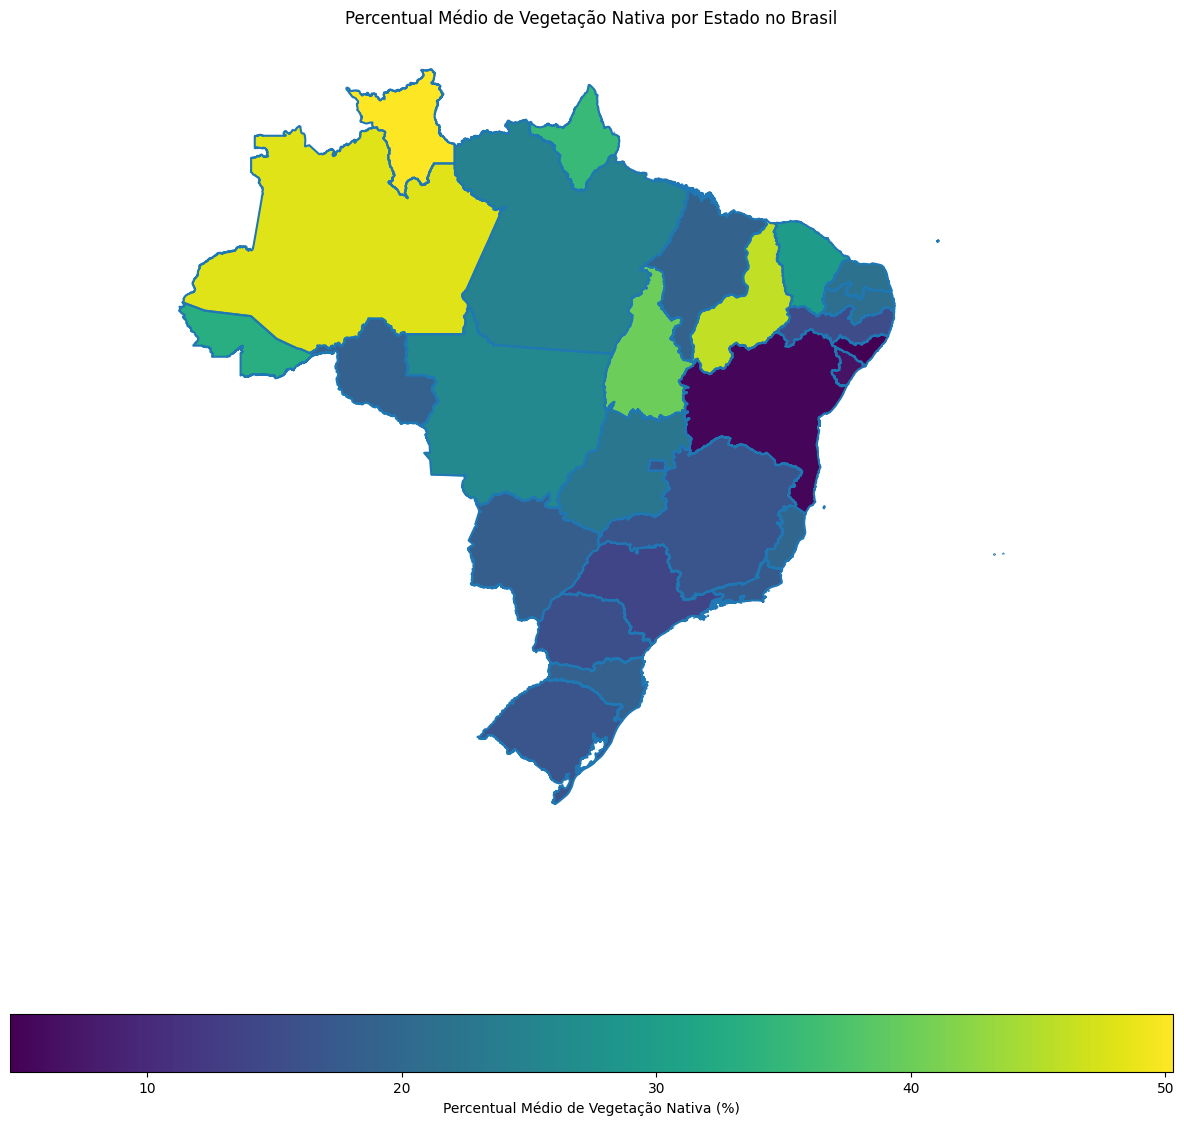

In [22]:

gdf = read_state()

gdf = gdf.merge(df_estados, how='left', left_on='abbrev_state', right_on='uf')

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
gdf.boundary.plot(ax=ax)
gdf.plot(column='percentual_medio_vegetacao_nativa', ax=ax, legend=True,
         legend_kwds={'label': "Percentual Médio de Vegetação Nativa (%)",
                      'orientation': "horizontal"})

plt.title('Percentual Médio de Vegetação Nativa por Estado no Brasil')
plt.axis('off')
plt.show()

In [22]:
percentual_evolucao_por_ano_query = """
WITH area_percentuais AS (
    SELECT
        EXTRACT(YEAR FROM TIMESTAMP(data_ultima_retificacao)) AS ano,
        area_remanescente_vegetacao_nativa / area_do_imovel AS percentual_vegetacao_nativa
    FROM
        `temas_ambientais.temas-ambientais_silver`
    WHERE
        area_do_imovel > 0
)
SELECT
    ano,
    AVG(percentual_vegetacao_nativa) * 100 AS percentual_medio_vegetacao_nativa
FROM
    area_percentuais
GROUP BY
    ano
ORDER BY
    ano
"""

In [27]:
query_job = client.query(percentual_evolucao_por_ano_query)
results = query_job.result()

data = []
for row in results:
    data.append((row.ano, row.percentual_medio_vegetacao_nativa))
    print(f"Ano: {row.ano}, Percentual Médio de Vegetação Nativa: {row.percentual_medio_vegetacao_nativa:.2f}%")

Ano: 2014, Percentual Médio de Vegetação Nativa: 20.80%
Ano: 2015, Percentual Médio de Vegetação Nativa: 18.71%
Ano: 2016, Percentual Médio de Vegetação Nativa: 18.95%
Ano: 2017, Percentual Médio de Vegetação Nativa: 17.19%
Ano: 2018, Percentual Médio de Vegetação Nativa: 18.67%
Ano: 2019, Percentual Médio de Vegetação Nativa: 16.56%
Ano: 2020, Percentual Médio de Vegetação Nativa: 17.64%
Ano: 2021, Percentual Médio de Vegetação Nativa: 17.63%
Ano: 2022, Percentual Médio de Vegetação Nativa: 18.53%


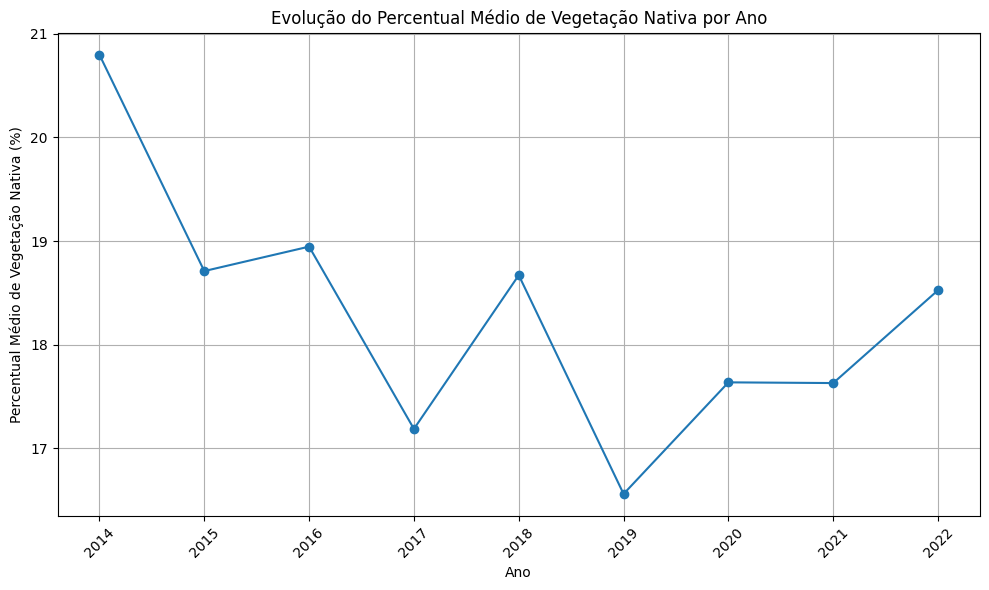

In [28]:
df = pd.DataFrame(data, columns=['Ano', 'Percentual Médio de Vegetação Nativa'])

plt.figure(figsize=(10, 6))
plt.plot(df['Ano'], df['Percentual Médio de Vegetação Nativa'], marker='o')
plt.title('Evolução do Percentual Médio de Vegetação Nativa por Ano')
plt.xlabel('Ano')
plt.ylabel('Percentual Médio de Vegetação Nativa (%)')
plt.grid(True)
plt.xticks(df['Ano'].astype(int), rotation=45)
plt.tight_layout()

## Consulta 5
Construa uma consulta que mostre a contagem de propriedades rurais por estado.

In [24]:
contagem_propriedades_por_estado_query = """
SELECT
    uf,
    COUNT(*) AS num_propriedades
FROM
    `temas_ambientais.temas-ambientais_silver`
GROUP BY
    uf
ORDER BY
    num_propriedades DESC
"""

In [25]:
query_job = client.query(contagem_propriedades_por_estado_query)
results = query_job.result()
df = results.to_dataframe()

In [30]:
df

,uf,num_propriedades
0,SP,339357
1,BA,196708
2,MG,165395
3,PA,140427
4,MA,96379
5,MT,82195
6,CE,74341
7,PR,69870
8,RS,67360
9,PE,60042


## Consulta 6
Faça a média de área entre todas as propriedades. Calcule quantas propriedades por estado, estão acima da média.

In [31]:
media_area_query = """
SELECT
    AVG(area_do_imovel) AS media_area
FROM
    `temas_ambientais.temas-ambientais_bronze`
"""

query_job = client.query(media_area_query)
media_area_result = query_job.result()
media_area = list(media_area_result)[0].media_area
print(f"Média de área: {media_area}")

Média de área: 92.05389711573343


In [32]:
contagem_propriedades_acima_media_query = f"""
SELECT
    uf,
    COUNT(*) AS num_propriedades_acima_media
FROM
    `temas_ambientais.temas-ambientais_bronze`
WHERE
    area_do_imovel > {media_area}
GROUP BY
    uf
ORDER BY
    num_propriedades_acima_media DESC
"""

query_job = client.query(contagem_propriedades_acima_media_query)
results = query_job.result()

df = results.to_dataframe()


In [33]:
df

,uf,num_propriedades_acima_media
0,MG,107875
1,PA,86698
2,MT,78569
3,GO,61385
4,BA,50508
5,SP,45229
6,MA,42202
7,RS,40274
8,MS,33762
9,TO,33389
